In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster, TimestampedGeoJson, HeatMapWithTime
from pandas.api.types import CategoricalDtype
import json
import numpy as np

In [2]:
with open('../data/small-areas-for-census-of-land-use-and-employment-clue.geojson') as f:
    districts = json.load(f)

df = pd.read_csv("../data/trees-with-species-and-dimensions-urban-forest.csv")
df = df[df['Year Planted'] > 2004]
df['Year Planted'] = pd.to_datetime(df['Year Planted'], format='%Y')
df.head()

,CoM ID,Common Name,Scientific Name,Genus,Family,Diameter Breast Height,Year Planted,Date Planted,Age Description,Useful Life Expectency,Useful Life Expectency Value,Precinct,Located in,UploadDate,CoordinateLocation,Latitude,Longitude,Easting,Northing,geolocation
0,1440992,River red gum,Eucalyptus camaldulensis,Eucalyptus,Myrtaceae,NaN,2009-01-01,2009-12-14,NaN,NaN,NaN,NaN,Park,2021-01-10,"-37.789042536009, 144.94750113149306",-37.789043,144.947501,319271.37,5815606.69,"-37.789042536009, 144.94750113149306"
1,1286119,River red gum,Eucalyptus camaldulensis,Eucalyptus,Myrtaceae,80.0,2008-01-01,2008-07-16,Mature,31-60 years,60.0,NaN,Park,2021-01-10,"-37.78989006812276, 144.9256959906416",-37.789890,144.925696,317353.24,5815470.25,"-37.78989006812276, 144.9256959906416"
2,1439848,European nettle tree,Celtis australis,Celtis,Cannabaceae,4.0,2009-01-01,2009-09-08,Juvenile,31-60 years,60.0,NaN,Street,2021-01-10,"-37.795227592098875, 144.91940533967247",-37.795228,144.919405,316812.46,5814865.65,"-37.795227592098875, 144.91940533967247"
3,1584631,Swamp Sheoak,Casuarina obesa,Casuarina,Casuarinaceae,NaN,2015-01-01,2015-06-18,NaN,NaN,NaN,NaN,Park,2021-01-10,"-37.795178798251044, 144.95235531785673",-37.795179,144.952355,319713.76,5814935.15,"-37.795178798251044, 144.95235531785673"
4,1286271,Golden Poplar,Populus x canadensis,Populus,Salicaceae,35.0,2008-01-01,2008-12-18,Semi-Mature,31-60 years,60.0,NaN,Street,2021-01-10,"-37.7904175404039, 144.92779056976474",-37.790418,144.927791,317538.99,5815415.81,"-37.7904175404039, 144.92779056976474"


https://yaleclimateconnections.org/2015/08/melbourne-planting-an-urban-forest/

Detailed strategy - https://www.melbourne.vic.gov.au/sitecollectiondocuments/urban-forest-strategy.pdf

Art campaign - https://climarte.org/project/tree-project/

In [3]:
def prepare_data(category, cut_off=20):
    species = df.groupby([category]).count()['CoM ID'].sort_values(ascending=False)
    species_cum_ratio = species.cumsum()/species.sum()
    most_popular_species = species_cum_ratio[:cut_off] 

    species_count = df.loc[df[category].isin(most_popular_species.index)].groupby([category, 'Year Planted']).count()['CoM ID'].reset_index()
    trees_by_year = dict(df.groupby(['Year Planted']).count()['CoM ID'].cumsum())

    species_count = species_count.sort_values([category, 'Year Planted'])
    species_count['CoM ID'] = species_count.groupby(category)['CoM ID'].cumsum()
    species_count['CoM ID'] = species_count['CoM ID']/species_count['Year Planted'].map(trees_by_year)

    return species_count

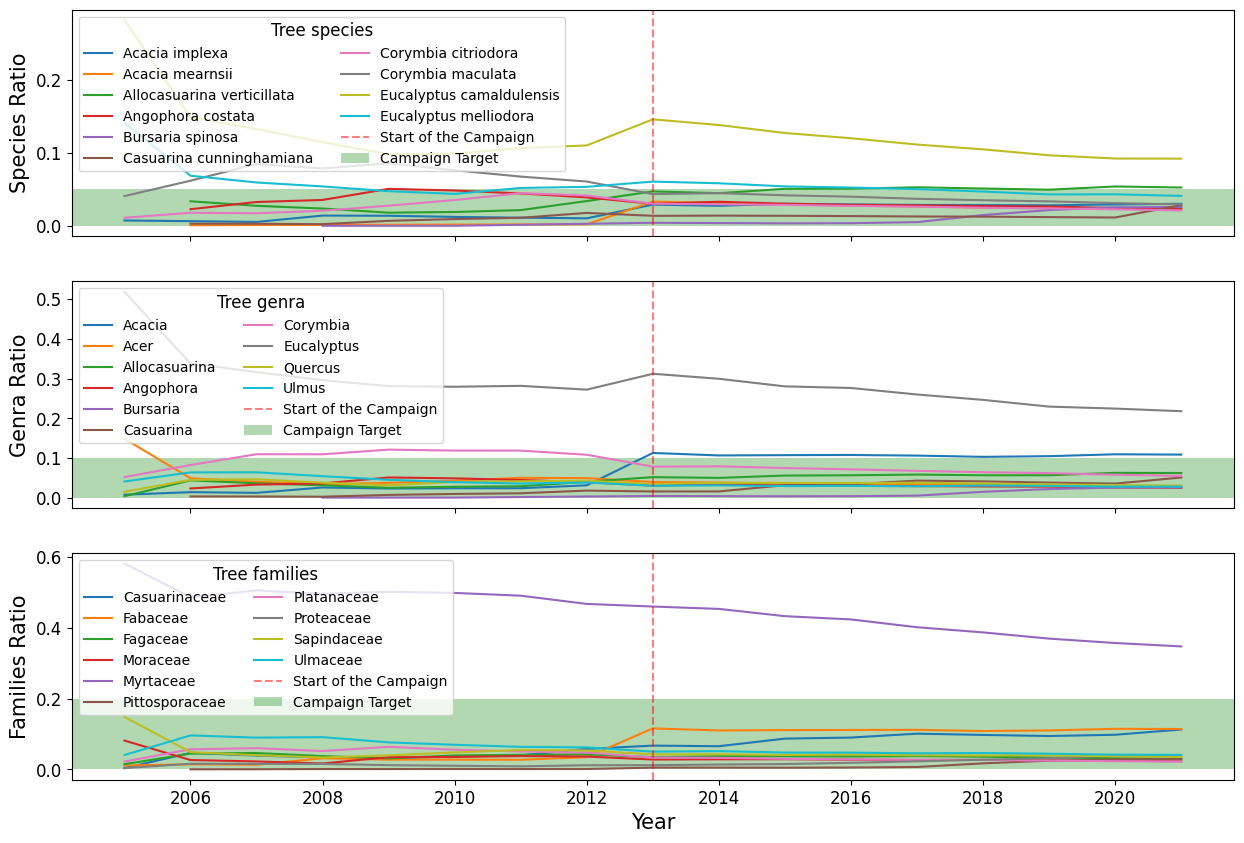

In [40]:
species_count = prepare_data('Scientific Name', cut_off=10)
genus_count = prepare_data('Genus', cut_off=10)
family_count = prepare_data('Family', cut_off=10)

_, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

for name, group in species_count.groupby('Scientific Name'):
    axes[0].plot(group['Year Planted'], group['CoM ID'], label=name)

axes[0].axvline(x=pd.to_datetime(2013, format='%Y'), color='r', linestyle='--', label='Start of the Campaign', alpha=0.5)
# axes[0].axhline(y=0.05, color='b', linestyle='--', label='Campaign Target', alpha=0.5)
axes[0].axhspan(0.0, 0.05, facecolor='green', alpha=0.3, label='Campaign Target')
axes[0].legend(ncols=2, title='Tree species', loc='upper left', title_fontsize=12)
axes[0].set_ylabel('Species Ratio', fontsize=15)
axes[0].yaxis.set_tick_params(labelsize=12)

for name, group in genus_count.groupby('Genus'):
    axes[1].plot(group['Year Planted'], group['CoM ID'], label=name)

axes[1].axvline(x=pd.to_datetime(2013, format='%Y'), color='r', linestyle='--', label='Start of the Campaign', alpha=0.5)
# axes[1].axhline(y=0.1, color='b', linestyle='--', label='Campaign Target', alpha=0.5)
axes[1].axhspan(0.0, 0.1, facecolor='green', alpha=0.3, label='Campaign Target')
axes[1].legend(ncols=2, title='Tree genra', loc='upper left', title_fontsize=12)
axes[1].set_ylabel('Genra Ratio', fontsize=15)
axes[1].yaxis.set_tick_params(labelsize=12)

for name, group in family_count.groupby('Family'):
    axes[2].plot(group['Year Planted'], group['CoM ID'], label=name)

axes[2].axvline(x=pd.to_datetime(2013, format='%Y'), color='r', linestyle='--', label='Start of the Campaign', alpha=0.5)
# axes[2].axhline(y=0.2, color='b', linestyle='dotted', label='Campaign Target', alpha=0.5)
axes[2].axhspan(0.0, 0.2, facecolor='green', alpha=0.3, label='Campaign Target')
axes[2].legend(ncols=2, title='Tree families', loc='upper left', title_fontsize=12)
axes[2].set_ylabel('Families Ratio', fontsize=15)
axes[2].yaxis.set_tick_params(labelsize=12)

plt.xlabel('Year', fontsize=15)
plt.xticks(fontsize=12)
plt.show()

In [5]:
data_heat_map = df[df['Located in'] == 'Street']
years = ['2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021']
cat_type = CategoricalDtype(categories=years, ordered=True)
data_heat_map['Year Planted C'] = data_heat_map['Year Planted'].astype(str).astype(cat_type)

data_heat_map = [[[row['Latitude'],row['Longitude']] for _, row in data_heat_map[data_heat_map['Year Planted C'] == y].iterrows()] for y in years]

heat_map = folium.Map(location=[-37.820935, 144.946457], zoom_start=12)
# folium.GeoJson(districts).add_to(heat_map)

popup = folium.GeoJsonPopup(fields=["featurenam"])
folium.GeoJson(
    districts,
    highlight_function=lambda feature: {
        "fillColor": (
            "green" if "e" in feature["properties"]["featurenam"].lower() else "#ffff00"
        ),
    },
    popup=popup,
    popup_keep_highlighted=True,
).add_to(heat_map)

HeatMapWithTime(data_heat_map, auto_play=True, index=years).add_to(heat_map)
heat_map

C:\Users\jwisn\AppData\Local\Temp\ipykernel_25596\549463717.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_heat_map['Year Planted C'] = data_heat_map['Year Planted'].astype(str).astype(cat_type)
